In [1]:
!pip install -q 'lalsuite==7.11' 'PyCBC==2.0.5'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2

### Preconditioning the Data

1.Reduce the dynamic range of the data and to suppress low frequency behavior that can introduce numerical artefacts.<br>
2.Reduce the sample rate of the data if high frequency content is not important.

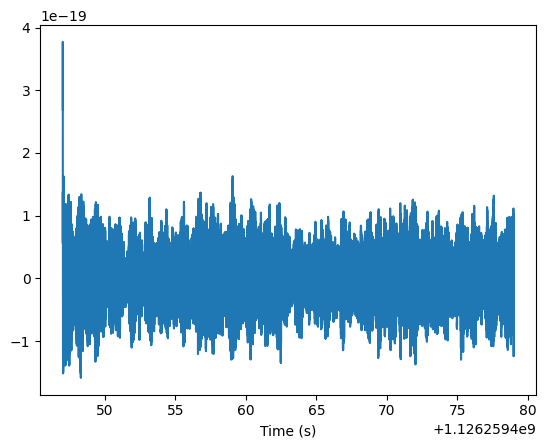

In [2]:
import matplotlib.pyplot as plt
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger= Merger("GW150914")
strain=merger.strain('L1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

plt.plot(strain.sample_times, strain)
plt.xlabel('Time (s)')
plt.show()

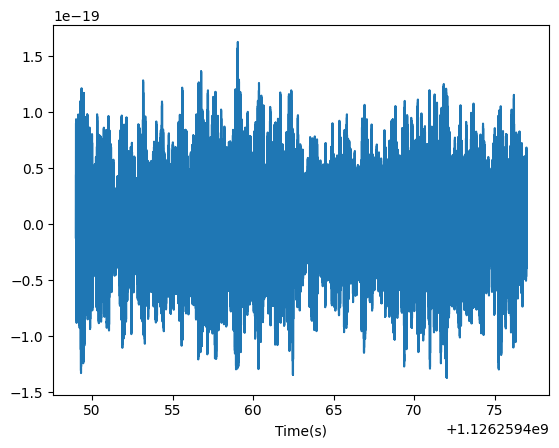

In [3]:
# Remove 2 seconds of data from both the beginning and end to prevent filter wraparound

conditioned=strain.crop(2,2)
plt.plot(conditioned.sample_times,conditioned)
plt.xlabel('Time(s)')
plt.show()

### Calculate the Power Spectral Density



In [4]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

#use samples of 4s for Welch PSD Estimation
psd=conditioned.psd(4)

# Interpolate psd to match data
psd=interpolate(psd,conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds to emphasise relevant signals and deemphasise noise dominated frequencies
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

### Template Waveform

Assume equal masses, and non-rotating black holes which is within the posterior probability of GW150914.

In [5]:
from pycbc.waveform import get_td_waveform

m=36
hp,hc=get_td_waveform(approximant='SEOBNRv4_opt',
                      mass1=m,
                      mass2=m,
                      delta_t=conditioned.delta_t,
                      f_lower=20)

# Resize the vector to match data
hp.resize(len(conditioned))

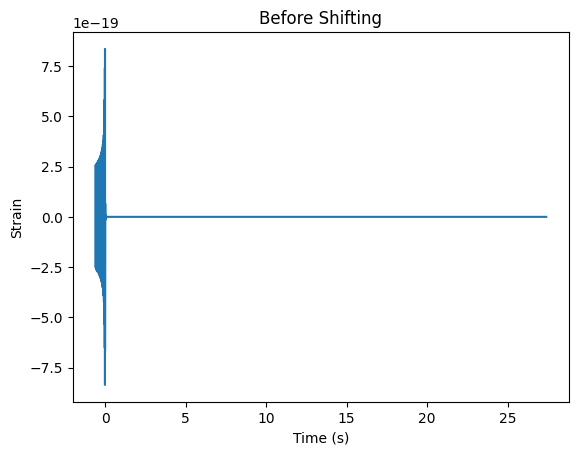

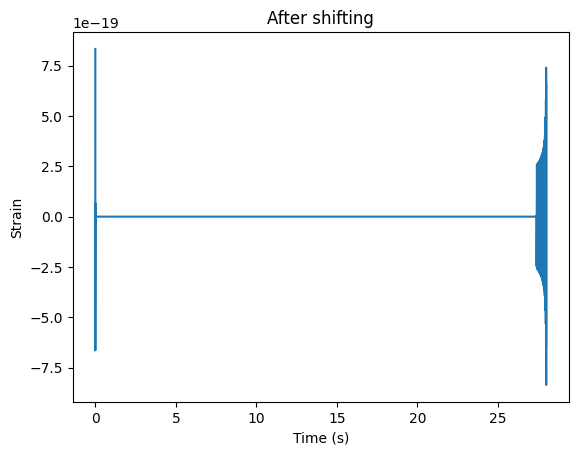

In [7]:
plt.figure()
plt.title('Before Shifting')
plt.plot(hp.sample_times,hp)
plt.xlabel('Time (s)')
plt.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

plt.figure()
plt.title('After shifting')
plt.plot(template.sample_times, template)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.show()

### Calculate the Signal-to-Noise Time Series



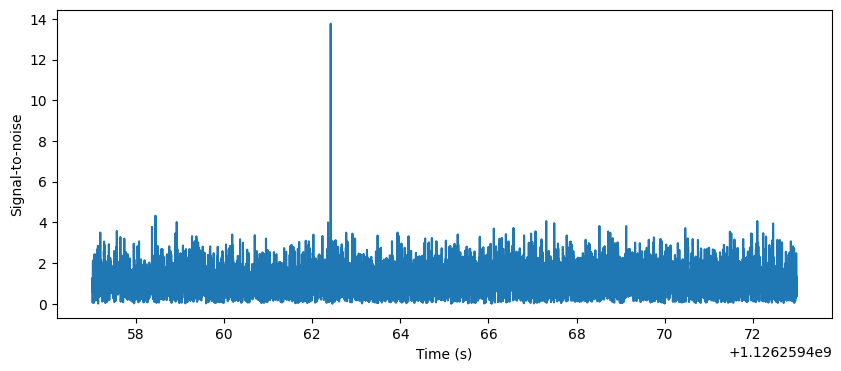

Signal at 1126259462.4174805s with SNR 13.760293599016979


In [9]:
from pycbc.filter import matched_filter
import numpy as np

snr=matched_filter(template,conditioned, psd=psd, low_frequency_cutoff=20)

# Remove 4s(b,e) for time corrupted by PSD filtering(above) and 4s for artefacts of template
snr = snr.crop(4 + 4, 4)

# Take an abs since we don't care about phase
plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("Signal at {}s with SNR {}".format(time, abs(snrp)))

## Aligning and Subtracting the Proposed Signal


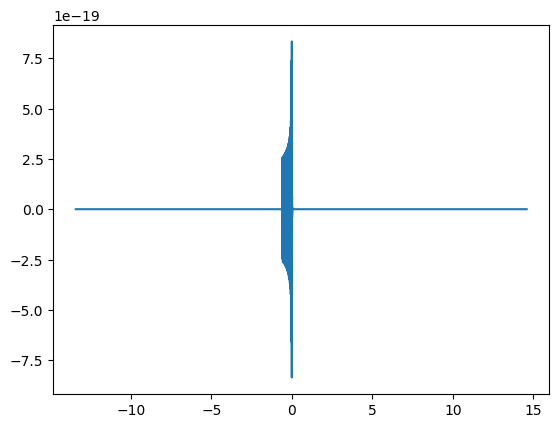

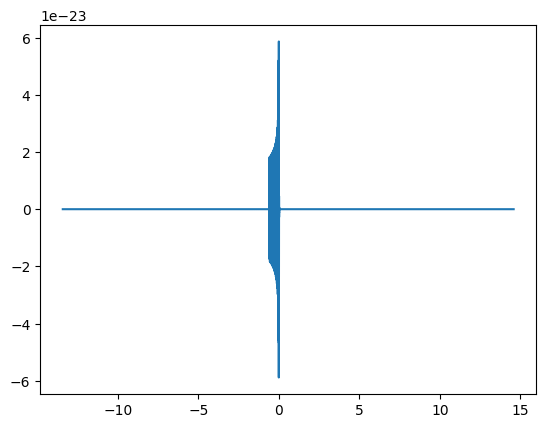

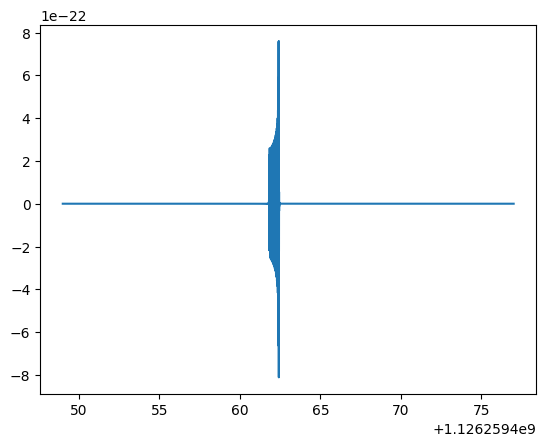

In [14]:
from pycbc.filter import sigma

# Shift the template to the peak time
dt=time-conditioned.start_time
aligned=template.cyclic_time_shift(dt)
plt.plot(aligned.sample_times,aligned)
plt.show()

# Normalise the template to have SNR 1
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)
plt.plot(aligned.sample_times,aligned)
plt.show()

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time
plt.plot(aligned.sample_times,aligned)
plt.show()

### Visualize the Overlap Between the Signal and Data


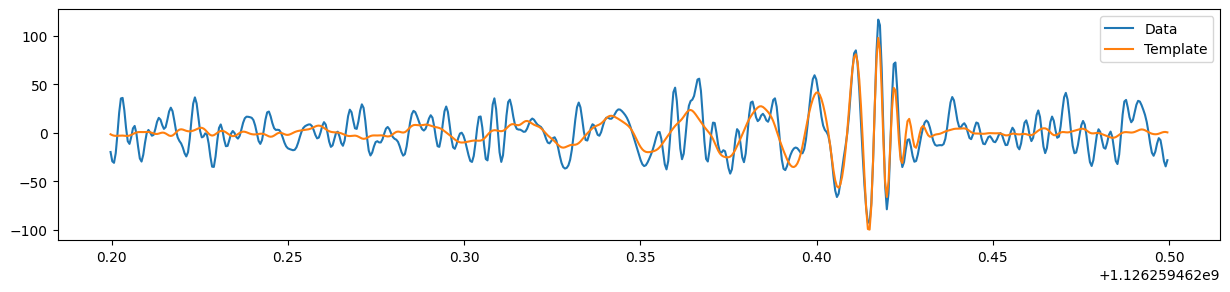

In [15]:
# Whiten both the template and the data
white_data=(conditioned.to_frequencyseries()/psd**0.5).to_timeseries()
white_template=(aligned.to_frequencyseries()/psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

plt.figure(figsize=[15, 3])
plt.plot(white_data.sample_times, white_data, label="Data")
plt.plot(white_template.sample_times, white_template, label="Template")
plt.legend()
plt.show()

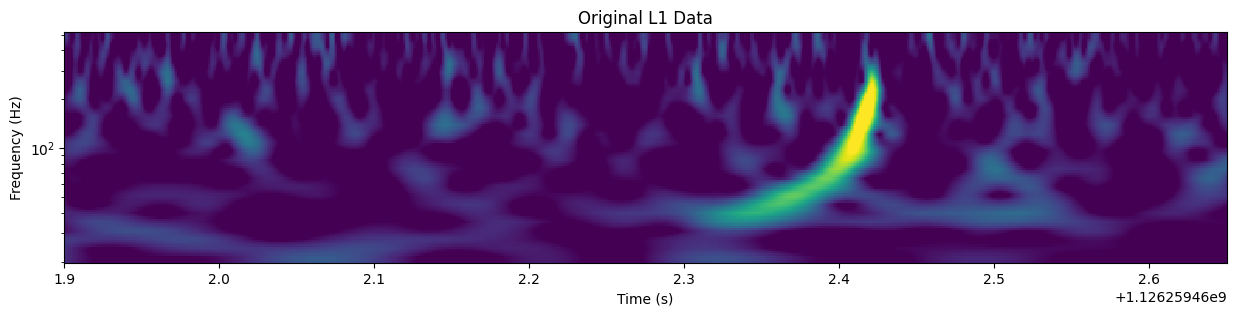

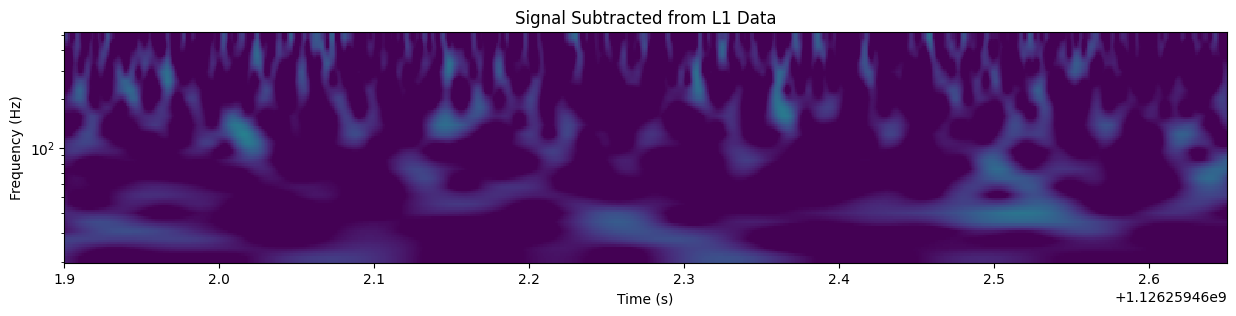

In [17]:
subtracted = conditioned - aligned


for data, title in [(conditioned, 'Original L1 Data'),
                    (subtracted, 'Signal Subtracted from L1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 512))
    plt.figure(figsize=[15, 3])
    plt.title(title)
    plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading='auto')
    plt.yscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlim(merger.time - 0.5, merger.time + 0.25)
    plt.show()